In [1]:
import datetime
import dateutil.parser
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import scipy
import seaborn as sns
import talib
import time

from statsmodels.tsa.stattools import coint
from tqdm.notebook import tqdm
from urllib.parse import urlencode

plt.rcParams["figure.figsize"] = (20, 10)

In [2]:

def fetch_ohlc(sym, binsize='1m', **kwargs):
    # https://docs.bitmex.com/api-explorer/get-trade-bucketed    
    query = {'symbol': sym, 'binSize': binsize, 'count': 1000, 'reverse': 'true'} | kwargs
    r = requests.get(f'https://www.bitmex.com/api/v1/trade/bucketed?{urlencode(query)}')
    if int(r.headers['x-ratelimit-remaining']) < 10:
        wait = int(r.headers['x-ratelimit-reset']) - time.time()
        time.sleep(wait + 5)
    return r.json()


def data_ohlc(sym, binsize='1m', count=5000):
    rows = fetch_ohlc(sym, binsize=binsize, endTime=datetime.date.today().isoformat())
    lookup = {'1m': 'minutes', '1h': 'hours', '1d': 'days'}
    key = lookup[binsize]
    
    while len(rows) < count:
        end_time = dateutil.parser.isoparse(rows[-1]['timestamp'])
        end_time -= datetime.timedelta(**{key: 1})
        end_iso = end_time.replace(tzinfo=None).isoformat() + 'Z'
        data = fetch_ohlc(sym, binsize=binsize, endTime=end_iso)
        if len(data) == 0:
            break
        rows.extend(data)
        
    cf = pd.DataFrame(rows).sort_values('timestamp')
    return cf.drop_duplicates().reset_index(drop=True)


In [3]:
C = fetch_ohlc('ETHUSD')
C[0]

{'timestamp': '2025-12-15T15:00:00.000Z',
 'symbol': 'ETHUSD',
 'open': 3055.9,
 'high': 3060.09,
 'low': 3050.28,
 'close': 3050.49,
 'trades': 134,
 'volume': 936,
 'vwap': 3055.67,
 'lastSize': 1,
 'turnover': 286010142,
 'homeNotional': 82.53968253968254,
 'foreignNotional': 252213.52910052906}

  0%|          | 0/2 [00:00<?, ?it/s]

,time,XBTUSD,XBTH26,spread
0,2025-07-02T05:00:00.000Z,106359.6,106650.0,290.4
1,2025-07-02T06:00:00.000Z,106608.1,106650.0,41.9
2,2025-07-02T07:00:00.000Z,106990.2,106650.0,-340.2
3,2025-07-02T08:00:00.000Z,107075.9,112395.0,5319.1
4,2025-07-02T09:00:00.000Z,107722.8,112650.0,4927.2
...,...,...,...,...
3975,2025-12-14T20:00:00.000Z,88633.1,89636.0,1002.9
3976,2025-12-14T21:00:00.000Z,88521.9,89590.0,1068.1
3977,2025-12-14T22:00:00.000Z,88441.9,89397.0,955.1
3978,2025-12-14T23:00:00.000Z,88373.3,89256.0,882.7


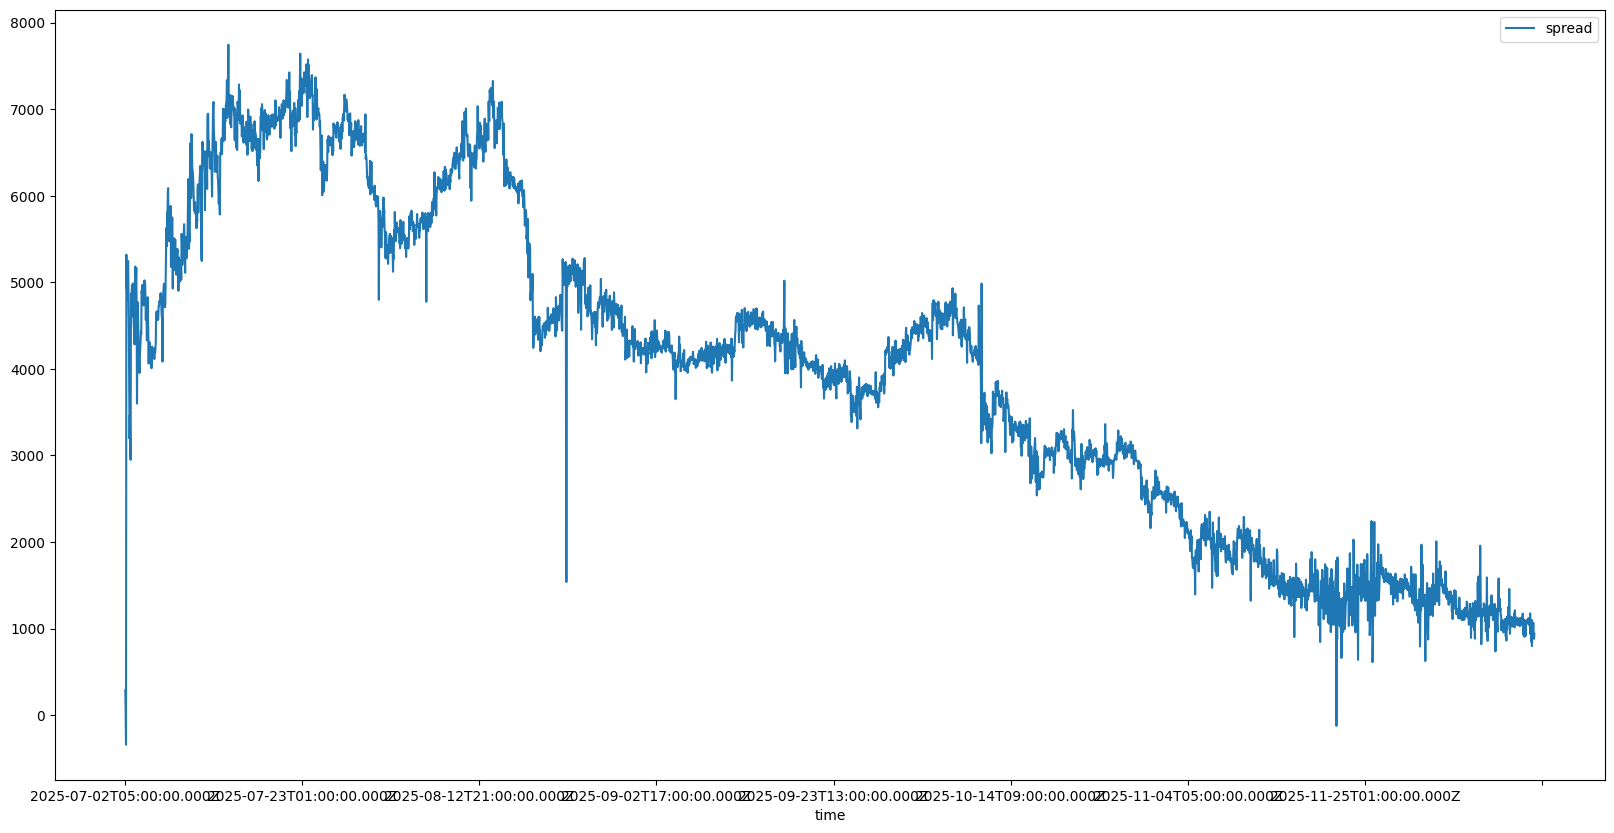

In [4]:
syms = ['XBTUSD', 'XBTH26']
times = set()
frames = []

for sym in tqdm(syms):
    cf = data_ohlc(sym, binsize='1h')
    xf = cf[['timestamp', 'close']]
    xf.columns = ['time', sym]
    times |= set(xf['time'])
    frames.append(xf)
    
dh = pd.DataFrame(sorted(times), columns=['time'])

for xf in frames:
    dh = dh.merge(xf, on='time', how='left')
    
dh = dh.dropna().reset_index(drop=True)

dh['spread'] = dh['XBTH26'] - dh['XBTUSD']
dh.plot(x='time', y='spread')

dh

In [5]:
syms = ['XBTUSD', 'XBTH26']
times = set()
frames = []

for sym in tqdm(syms):
    cf = data_ohlc(sym, binsize='1m')
    xf = cf[['timestamp', 'close']]
    xf.columns = ['time', sym]
    times |= set(xf['time'])
    frames.append(xf)
    
df = pd.DataFrame(sorted(times), columns=['time'])

for xf in frames:
    df = df.merge(xf, on='time', how='left')
    
df

  0%|          | 0/2 [00:00<?, ?it/s]

,time,XBTUSD,XBTH26
0,2025-12-11T12:41:00.000Z,90319.9,91417.5
1,2025-12-11T12:42:00.000Z,90234.1,91417.5
2,2025-12-11T12:43:00.000Z,90252.9,91417.5
3,2025-12-11T12:44:00.000Z,90261.4,91417.5
4,2025-12-11T12:45:00.000Z,90260.0,91417.5
...,...,...,...
4995,2025-12-14T23:56:00.000Z,88208.7,89202.0
4996,2025-12-14T23:57:00.000Z,88107.7,89202.0
4997,2025-12-14T23:58:00.000Z,88119.5,89095.0
4998,2025-12-14T23:59:00.000Z,88118.1,89095.0


In [6]:
P = df['XBTUSD'] # Perp
F = df['XBTH26'] # Future

tstat, pvalue, _ = coint(P, F, trend='ct')

# if pvalue < 0.05 then (y0, y1) are cointegrated
pvalue

2.1999603888398036e-14

```
P ~ const + beta * F
```

In [22]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts

N = 1000

P_train = P[:N]
F_train = F[:N]

P_test = P[N:]
F_test = F[N:]

def train_model(X, Y):
    Fc = sm.add_constant(Y)

    model = sm.OLS(X, Fc)
    results = model.fit()
    
    const = results.params[0]
    beta = results.params[1]

    return const, beta

train_model(P_train, F_train)

(1847.0227993017734, 0.9679930651312357)

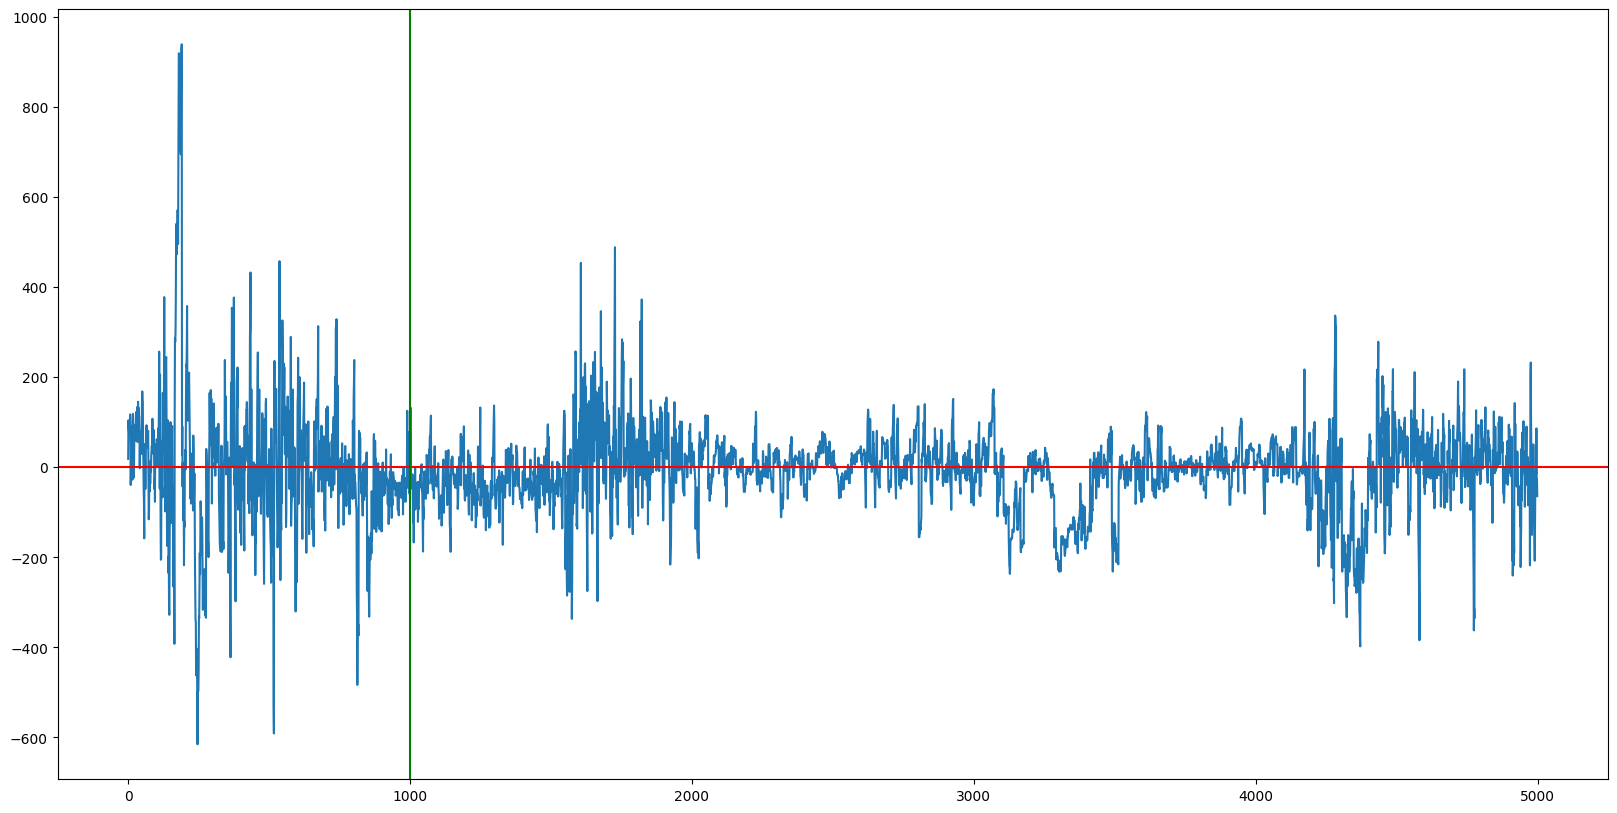

In [19]:
Z = (const + beta * F - P)

Z_train = Z[:N]

Z.plot()

plt.axhline(0, color='r')
plt.axvline(N, color='g')

The **Autocorrelation Function (ACF)** is a useful time series tool that measures the relationship
between a time series with a lagged version of itself over different time lags. E.g.
- Lag 1: correlation between observations at time `t` and `t-1`
- Lag 2: correlation between observations at time `t` and `t-2`
- etc...

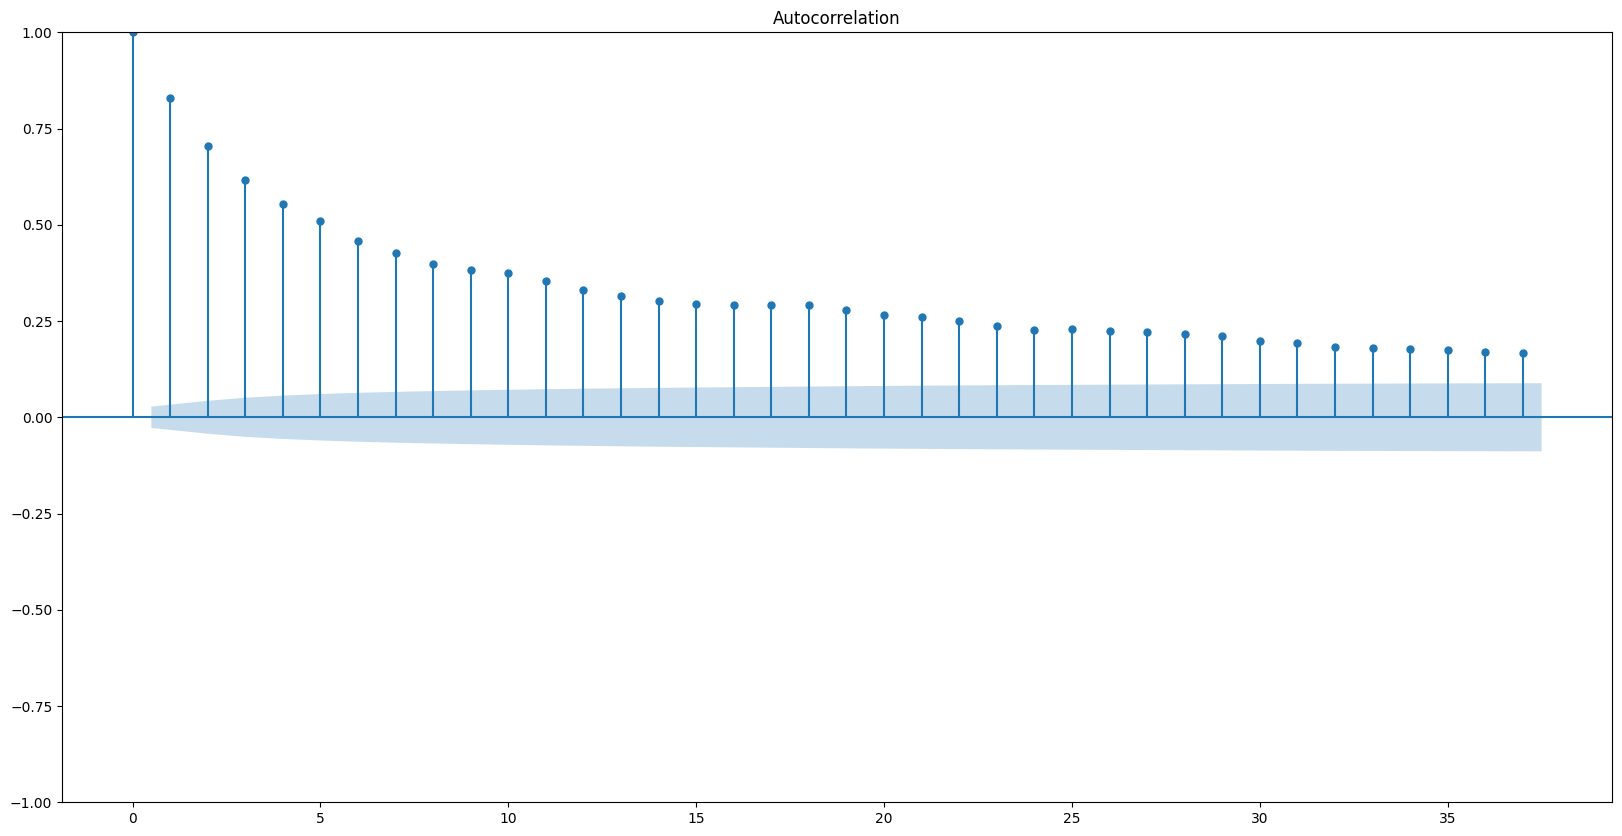

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(P - F);

In [20]:
mean, std = np.mean(Z_train), np.std(Z_train)
mean, std

(-1.0174844646826387e-09, 168.8868980892813)

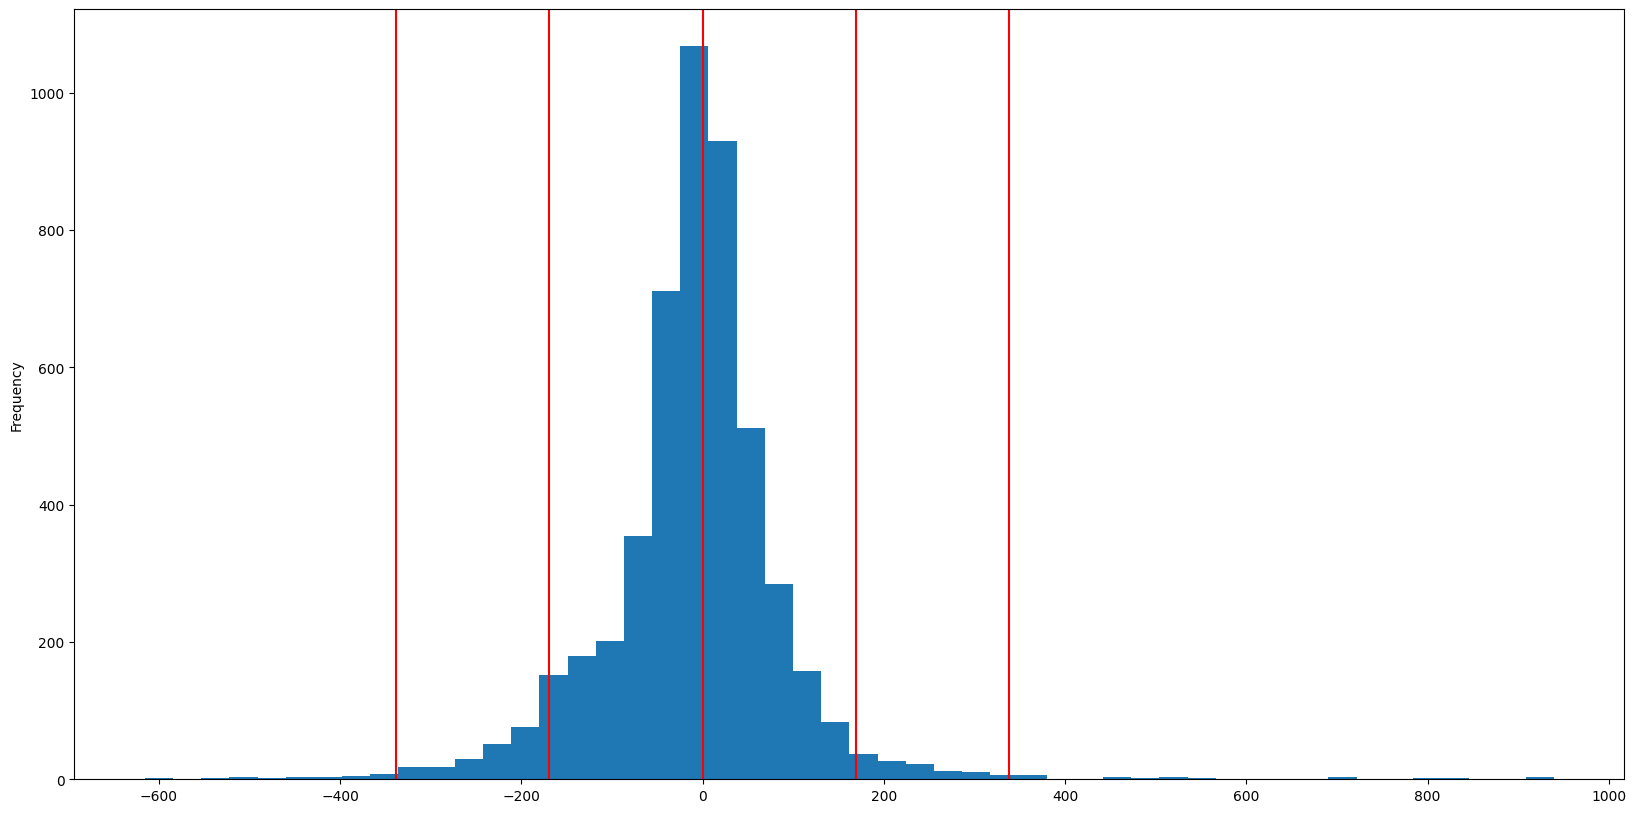

In [21]:
Z.plot(kind='hist', bins=50)

for i in [-2, -1, 0, 1, 2]:
    plt.axvline(i * std, color='r')

In [24]:
df

,time,XBTUSD,XBTH26
0,2025-12-11T12:41:00.000Z,90319.9,91417.5
1,2025-12-11T12:42:00.000Z,90234.1,91417.5
2,2025-12-11T12:43:00.000Z,90252.9,91417.5
3,2025-12-11T12:44:00.000Z,90261.4,91417.5
4,2025-12-11T12:45:00.000Z,90260.0,91417.5
...,...,...,...
4995,2025-12-14T23:56:00.000Z,88208.7,89202.0
4996,2025-12-14T23:57:00.000Z,88107.7,89202.0
4997,2025-12-14T23:58:00.000Z,88119.5,89095.0
4998,2025-12-14T23:59:00.000Z,88118.1,89095.0


In [41]:
Z_entry = 2 # when abs(Z) > 2 enter position assuming no risk
Z_close = 0 # if have position close it if crosses 0 

risk = 0
trades = []


for i, r in enumerate(df[N:].itertuples()):
    trade = 0
    # trade = +1: buy XBTH26, sell XBTUSD
    # trade = -1: sell XBTH26, buy XBTUSD  
    
    if i % 60 == 0:
        # retrain the model
        P_train = P[i:i+1000]
        F_train = F[i:i+1000]
        const, beta = train_model(P_train, F_train)
        std = np.std(const + beta * F_train - P_train)
    
    z = (const + beta * r.XBTH26 - r.XBTUSD) / std
    
    if risk == 0:
        if z > Z_entry: # enter short
            trade = -1
        elif z < -Z_entry: # enter long
            trade = 1
    elif risk > 0:
        if z > Z_close: # close long
            trade = -1
    else:
        if z < Z_close: # close short
            trade = 1
            
    risk += trade
    trades.append([r.time, std, trade])
    
    
tf = pd.DataFrame(trades, columns=['time', 'std', 'trade'])

xf = df.merge(tf, on='time', how='left')
xf[xf['trade']!=0].dropna()

,time,XBTUSD,XBTH26,std,trade
1546,2025-12-12T14:27:00.000Z,92113.9,93371.0,75.116293,-1.0
1551,2025-12-12T14:32:00.000Z,92196.0,93102.5,75.116293,1.0
1556,2025-12-12T14:37:00.000Z,92444.0,93344.0,75.116293,1.0
1559,2025-12-12T14:40:00.000Z,92426.4,93563.5,75.116293,-1.0
1566,2025-12-12T14:47:00.000Z,92607.1,93475.0,75.116293,1.0
...,...,...,...,...,...
4918,2025-12-14T22:39:00.000Z,88100.0,89171.0,96.623596,-1.0
4940,2025-12-14T23:01:00.000Z,88467.9,89256.0,96.623596,1.0
4943,2025-12-14T23:04:00.000Z,88205.4,89256.0,96.623596,-1.0
4975,2025-12-14T23:36:00.000Z,87739.0,88938.5,98.394664,-1.0


<Axes: ylabel='Frequency'>

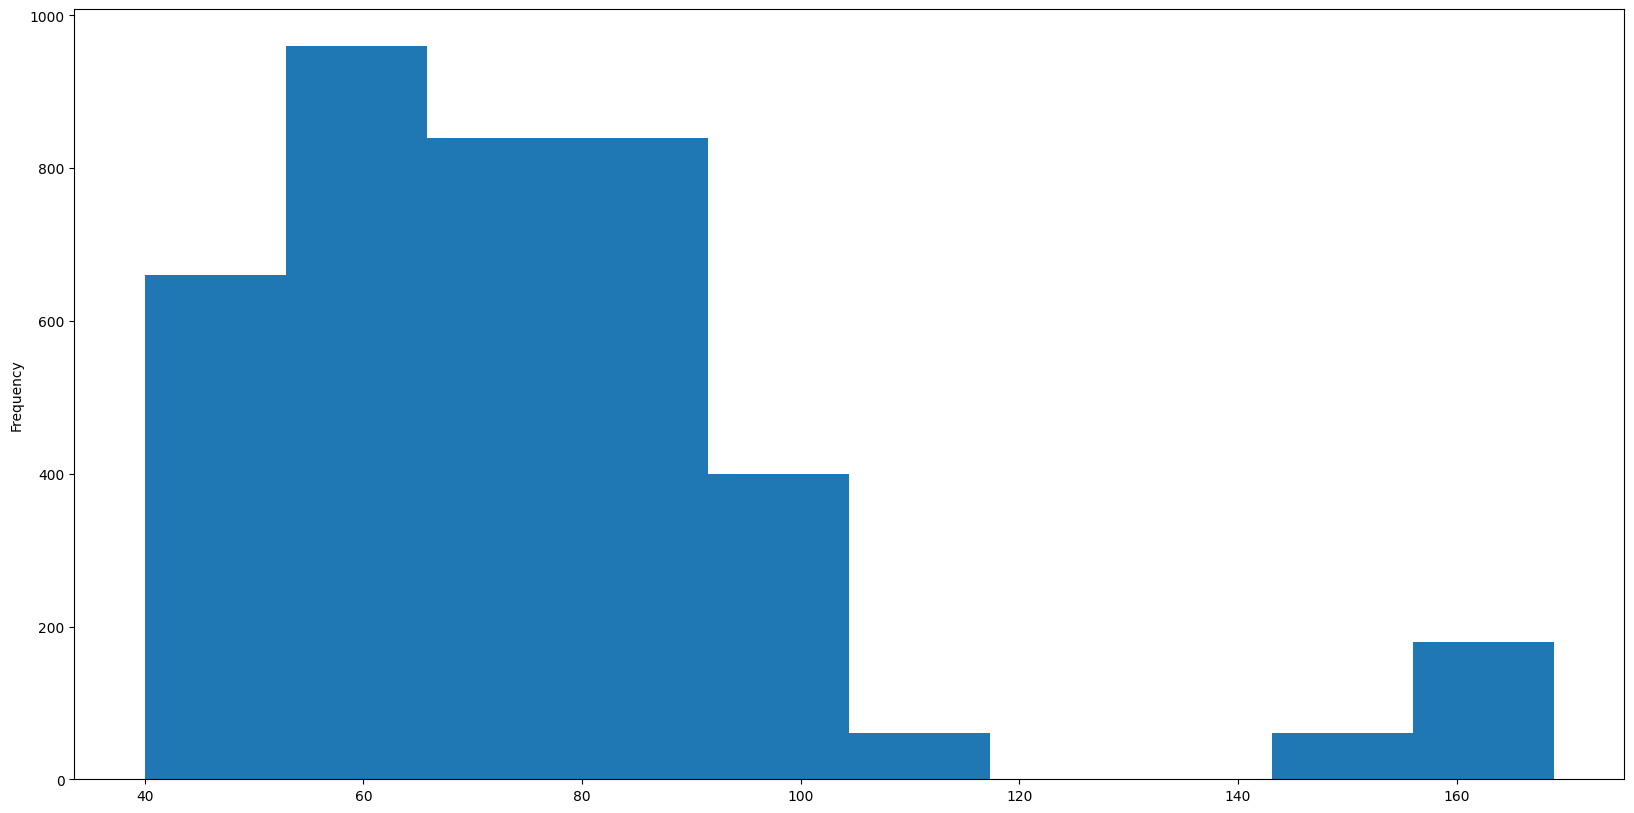

In [43]:
tf['std'].plot(kind='hist')

In [33]:
buy = 100
sell = 110

pct_gain = (sell - buy) / buy

# pnl = pct_gain * pos_size

pct_gain

0.1

,entry_time,exit_time,pnl,fee,total_pnl
0,2025-12-11T12:41:00.000Z,2025-12-11T12:42:00.000Z,-0.949957,2.0,-2.949957
1,2025-12-11T12:43:00.000Z,2025-12-11T12:44:00.000Z,0.094180,2.0,-4.855777
2,2025-12-11T12:45:00.000Z,2025-12-11T12:46:00.000Z,0.029914,2.0,-6.825863
3,2025-12-11T12:47:00.000Z,2025-12-11T12:48:00.000Z,-0.460877,2.0,-9.286740
4,2025-12-11T12:49:00.000Z,2025-12-11T12:50:00.000Z,1.584434,2.0,-9.702307
...,...,...,...,...,...
557,2025-12-14T19:41:00.000Z,2025-12-14T20:02:00.000Z,3.159819,2.0,-955.160167
558,2025-12-14T20:14:00.000Z,2025-12-14T20:18:00.000Z,2.994328,2.0,-954.165839
559,2025-12-14T22:33:00.000Z,2025-12-14T22:39:00.000Z,3.500771,2.0,-952.665068
560,2025-12-14T23:01:00.000Z,2025-12-14T23:04:00.000Z,2.976008,2.0,-951.689060


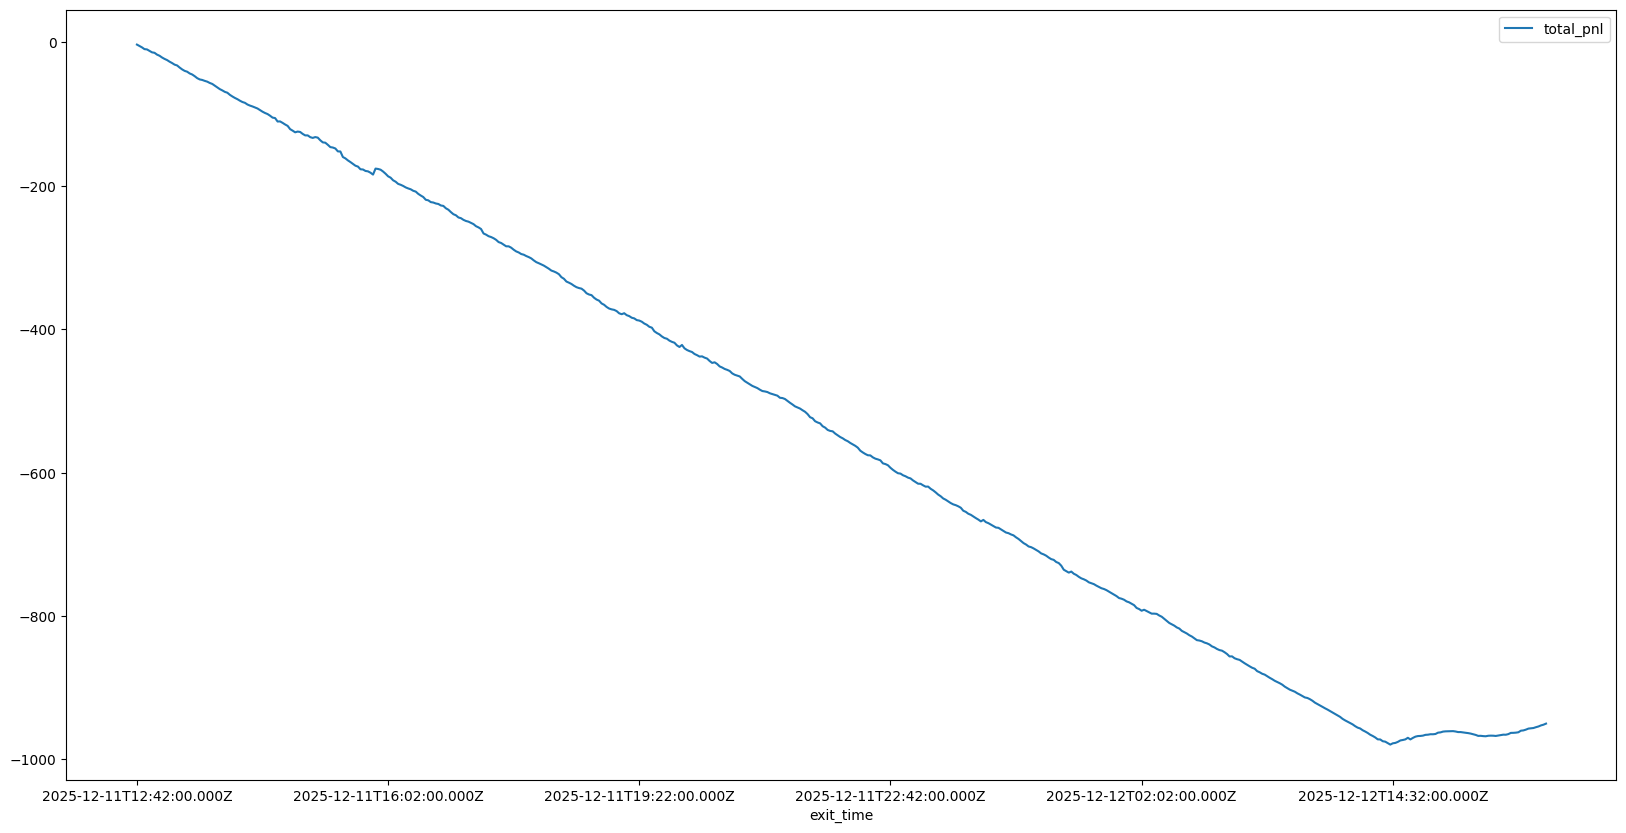

In [40]:
ff = xf[xf['trade']!=0].reset_index(drop=True)

pos_size = 1000
fee_rate = 5 * 1e-4
# fee_rate = 0
rows = []

for i, g in ff.groupby(ff.index // 2):
    r1, r2 = g.iloc[0], g.iloc[1]
    if r1.trade == 1:
        sell_P = r1.XBTUSD
        buy_F = r1.XBTH26
        buy_P = r2.XBTUSD
        sell_F = r2.XBTH26
    else:
        buy_P = r1.XBTUSD
        sell_F = r1.XBTH26
        sell_P = r2.XBTUSD
        buy_F = r2.XBTH26
        
    gain_P = (sell_P - buy_P) / buy_P
    gain_F = (sell_F - buy_F) / buy_F
    
    pnl = pos_size * (gain_P + gain_F)
    fee = 4 * pos_size * fee_rate
    rows.append([r1.time, r2.time, pnl, fee])
    
zf = pd.DataFrame(rows, columns=['entry_time', 'exit_time', 'pnl', 'fee'])

zf['total_pnl'] = (zf['pnl'] - zf['fee']).cumsum()

zf.plot(x='exit_time', y='total_pnl')
zf